# Задание 1.1. Полносвязные сети. Pytorch. [Кросспроверка. 10 баллов]

## DL курс на ВМК. Осень 2022

Перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

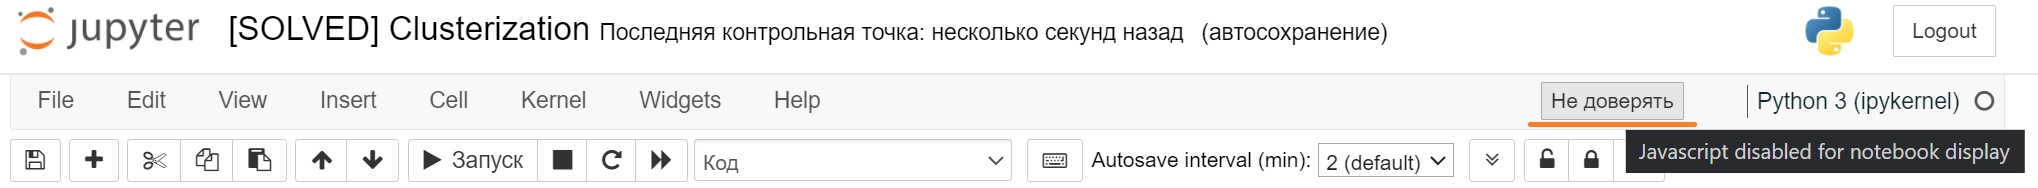

### Реализация нейронной сети

В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры, самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для реализации модели воспользуемся фреймворком **Pytorch**. Стандартным подходом при реализации нейросетевых моделей является её декомпозиция на отдельные блоки. С помощью данной библиотеки можно создавать как модели из готовых блоков-слоёв, так и реализовывать свои модули. При этом Pytorch скрывает все сложности, связанные с вычислениями выходов модели по её входам и подсчётом градиентов, что делает эту библиотеку особенно удобной при использовании *Градиентных методов оптимизации*, таких как **Стохастический Градиентный Спуск (SGD)**, **LBFGS** и других. 

In [1]:
import torch

import numpy as np

Для того, чтобы реализовать свой блок, нужно, чтобы он был отнаследован от базового класса для всех нейронных сетей `torch.nn.Module`. 

Затем, для удобства и в соответствии с общепринятой практикой, модуль должен реализовывать функцию `forward`.  В этой функции обычно реализуют основную логику вычислений в модуле, так называемый *прямой проход* через слой. Pytorch использует функцию `forward` для переопределения магического метода класса `__call__`, что позволяет использовать следующий синтаксический сахар для вычисления прямого прохода:
```python
# Два эквивалентных способа делать прямой проход через блок:
out = module(x)
out = module.forward(x)
```

Нужно отметить, что блоки являются лишь удобной обёрткой для вычислений и создания графа автоматического дифференцирования.

Рассмотрим простейший пример модуля, который реализует **Тождественное преобразование**:

In [2]:
class Identity(torch.nn.Module):
    def __init__(self):
        '''
        Конструктор блока. Здесь обычно создают обучаемые параметры и сохраняют переменные, 
            определяющие глобальное состояние слоя, а так же гиперпараметры
        Блок, может содержать в себе подблоки, которые также были отнаследованы от базового класса torch.nn.Module
        '''
        # Необходимо вызвать конструктор базового класса для корректной работы блока
        super().__init__()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Функция, реализующая прямой проход через слой. В процессе вычислений создаётся граф вычислений
            сквозь который выполняется автоматическое дифференцирование.
        '''
        return x
    
    def __repr__(self):
        '''
        Хорошей практикой является переопределение строкового представления для блоков
        Обычно, помимо названия класса также выводят гиперпараметры данного экземпляра класса
        '''
        return 'Identity()'

Создадим экземпляр данного слоя и проверим его работу:

In [3]:
identity_layer = Identity()
x = torch.randn([3, 5])

# Обратите внимание, метод __call__ был автоматически переопределён через вызов метода forward
print(x, identity_layer(x), sep='\n')
print(identity_layer, torch.equal(x, identity_layer(x)))

tensor([[-1.0925,  0.6559,  0.1477,  0.4315, -0.6404],
        [ 1.6545, -0.3239,  0.1898, -0.4209,  1.1387],
        [-0.6943, -0.1283,  0.9879, -1.4463, -1.0496]])
tensor([[-1.0925,  0.6559,  0.1477,  0.4315, -0.6404],
        [ 1.6545, -0.3239,  0.1898, -0.4209,  1.1387],
        [-0.6943, -0.1283,  0.9879, -1.4463, -1.0496]])
Identity() True


### Слой нелинейности ReLU

Теперь реализуем слой нелинейности $\text{ReLU}(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $\text{ReLU}$ к входному массиву.

In [4]:
class ReLU(torch.nn.Module):
    def __init__(self):
        '''
        Слой ReLU поэлементно применяет rectified linear unit к своему входу
        '''
        super().__init__()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Применяет ReLU ко входному тензору
        '''
        return torch.where(x > 0, x, 0)
      
    def __repr__(self):
        return 'ReLU()'

In [5]:
relu_layer = ReLU()
x = torch.randn([3, 5])

assert not torch.any(relu_layer(x) < 0)
assert torch.all(torch.eq(relu_layer(x), torch.nn.ReLU()(x)))

print(x, relu_layer(x), sep='\n')
print(relu_layer)

tensor([[-0.5319, -1.3652,  1.2293,  0.2266, -0.2937],
        [-1.5937, -0.9124, -1.1565,  0.0533, -0.1619],
        [-0.3640,  1.7807, -0.5456, -1.5767, -0.8609]])
tensor([[0.0000, 0.0000, 1.2293, 0.2266, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0533, 0.0000],
        [0.0000, 1.7807, 0.0000, 0.0000, 0.0000]])
ReLU()


### Полносвязный слой

Далее реализуем полносвязный слой без нелинейности `Linear`. У слоя два параметра: **матрица весов** и **вектор сдвига**. 

Основным преимуществом базового класса `torch.nn.Module` является наличие интерфейса работы с параметрами (обучаемые веса модели), буферами (необучаемые тензоры в модели) и подмодулями (то есть другие модули-наследники `torch.nn.Module`, которые в итоге создают иерархическую структуру модели).

Если параметры/буферы/подмодули зарегистрированы в модуле, то базовый класс позволяет удобно работать с этими сущностями. Рассмотрим основные методы:
* `parameters` — возвращает итератор по всем параметрам, зарегистрированным в данном модуле и всех его подмодулях
* `named_parameters` — возвращает итератор по всем параметрам и их именам, зарегистрированным в данном модуле и всех его подмодулях
* `buffers`/`named_buffers` — аналогичные функции для получения доступа к списку всех буферов
* `requires_grad_(requires_grad=True)` — in-place метод, включающий или выключающий подсчёт градиентов для параметров
* `to(device, dtype)` — изменение типа параметров и устройства на котором они располагаются
* `train`/`eval` — рекурсивное переключение режимов работы модулей. Обычно, перед обучением сети необходимо вызвать метод `train`, а перед тестированием (инференсом) — перевести в режим `eval`. Данные методы необходимы для корректной реализации таких методов регуляризации как BatchNorm и Dropout

Подробное описание работы этих и других доступных методов можно найти в [документации](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Теперь рассмотрим процесс регистрации параметров/буферов/подмодулей.
Существует два основных варианта регистрации:
1. **Неявная регистрация**, которая происходит в момент создания атрибута класса и присваивания ему класса-обёртки для параметров `torch.nn.Parameter` (для регистрации параметров) или наследника `torch.nn.Module` (для регистрации подмодулей). Обратите внимание, что **присваивание тензора не приводит к регистрации параметра**. Также, стоит отметить, что нет неявного способа регистрации буферов
2. **Явная регистрация** с использованием методов `register_parameter, register_buffer, register_module`.

По умолчанию при написании кода стоит отдавать предпочтение *неявной регистрации*.

Отдельно выделим частую ситуацию, в которой требуется зарегистрировать переменное (или просто достаточно большое число) параметров/подмодулей. Действительно, в современных моделях может быть десятки и сотни слоёв и тысячи тензоров-параметров, которые логично хранить в модели не в виде отдельных атрибутов, а в виде списка или словаря. Однако, сохранив параметры/подмодули в такую структуру данных, **неявная регистрация автоматически не сработает**. Чтобы обойти этот недостаток в **Pytorch** реализован набор контейнеров, которые при добавлении в них параметров будут производить их регистрацию в текущем блоке. Так, например, доступен контейнер для списка параметров `torch.nn.ParameterList` и контейнер для словаря параметров `torch.nn.ParameterDict`. Аналогичные [классы-контейнеры](https://pytorch.org/docs/stable/nn.html#containers) доступны и для модулей: `torch.nn.ModuleList`, `torch.nn.ModuleDict`. При реализации слоёв с фиксированным числом параметров (например, `Linear`) такие классы обычно не нужны.

Сразу обратим внимание на особо важный момент при работе с обучаемыми параметрами. Качество итоговой модели и процесс обучения может существенно зависеть от начальной инициализации параметров. Поэтому, **необходимо тщательно контролировать инициализацию**. В **Pytorch** общепринятым способом установки блока в исходное состояние является реализация метода `reset_parameters`, который выполняет правильную инициализацию обучаемых весов, отчищает буферы и так далее.

Реализуйте блок линейного слоя в ячейке ниже.

**Не используйте готовые реализации линейного слоя (из `torch.nn` и других модулей) в данном задании.**

In [6]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        '''
        Полносвязный слой — это слой выполняющий аффинное преобразование f(x) = x W + b
        '''
        super().__init__()
        
        # Создайте необходимые обучаемые параметры
        ### your code here
        self.in_f = in_features
        self.out_f = out_features
        self.weight = torch.nn.Parameter(torch.normal(mean=0, std=0.01, size=(in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.zeros(out_features))
        self.params = [self.weight, self.bias]
        
        # Выполните инициализацию весов
        
    def reset_parameters(self):
        '''
        Инициализация весов полносвязного слоя из нормального распределения с 
            нулевым средним и стандартным отклонением 0.01
        Вектор-смещение инициализируется нулями
        '''
        self.weight = torch.normal(mean=0, std=0.01, size=(self.in_f, self.out_f))
        self.bias = self.bias.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Выполнение аффинного преобразования f(x) = x W + b
        
        :param torch.Tensor x: входная матрица размера [batch_size, in_features]
        :returns: матрица размера [batch_size, out_features]
        '''
        return torch.mm(x, self.weight) + self.bias
    
    def __repr__(self):
        '''
        Опциональный метод для красивого вывода
        '''
        return 'Linear({0:d}, {1:d})'.format(*self.weight.shape)

In [7]:
linear_layer = Linear(3, 5)
x = torch.randn([2, 3])

print(x, linear_layer(x), sep='\n')
print(linear_layer)

tensor([[-0.3807, -0.1471,  1.1810],
        [-0.6477, -1.3212, -0.4519]])
tensor([[ 0.0062,  0.0078, -0.0040, -0.0114,  0.0017],
        [ 0.0084, -0.0098,  0.0174,  0.0344,  0.0051]], grad_fn=<AddBackward0>)
Linear(3, 5)


Блоки-наследники `torch.nn.Module` автоматически сохраняют информацию о своей структуре: параметрах, буферах. Например, можно получить генератор всех параметров в данном блоке (метод `parameters`). Более того, каждый параметр имеет своё уникальное имя (обычно оно совпадает с названием переменной, в которую соответствующий параметр был присвоен). Именованный список параметров можно получить через вызов метода `named_parameters`:

In [8]:
linear_layer, list(linear_layer.parameters()), list(linear_layer.named_parameters())

(Linear(3, 5), [Parameter containing:
  tensor([[-0.0063, -0.0058, -0.0040, -0.0171, -0.0227],
          [-0.0042,  0.0083, -0.0092, -0.0120,  0.0089],
          [ 0.0027,  0.0057, -0.0058, -0.0167, -0.0048]], requires_grad=True),
  Parameter containing:
  tensor([0., 0., 0., 0., 0.], requires_grad=True)], [('weight',
   Parameter containing:
   tensor([[-0.0063, -0.0058, -0.0040, -0.0171, -0.0227],
           [-0.0042,  0.0083, -0.0092, -0.0120,  0.0089],
           [ 0.0027,  0.0057, -0.0058, -0.0167, -0.0048]], requires_grad=True)),
  ('bias', Parameter containing:
   tensor([0., 0., 0., 0., 0.], requires_grad=True))])

### Реализация Softmax-слоя и функции потерь

Для решения задачи многоклассовой классификации обычно используют $Softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = \text{Softmax}(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по-английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K \mathbb{1}[y = i]\log \hat y^i,$$
где $\mathbb{1}[y = i]$ — индикатор принадлежности $i$-му классу.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение в точке $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.

Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \mathfrak{L} = \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}_{\theta}(x_i)) \rightarrow \min_{\theta}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}_{\theta}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $\theta$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.

Реализуйте функцию потерь `CrossEntropyLoss`. Функции потерь иногда наследуют от базового класса `torch.nn.Module`, но часто сам слой не включают в нейронную сеть. Во время вычисления `CrossEntropyLoss` усредняйте (а не суммируйте) значения функции потерь по батчу. Обычно так делают для того, чтобы при двух запусках обучения нейронной сети с разными размерами батча получаемые значения функции потерь у этих сетей были сравнимы.

Реализуйте блок для вычисления кросс-энтропии в ячейке ниже.

При вычислениях логсофтмакса необходимо использовать численно стабильные методы. В частности, воспользуйтесь **Exp-Normalize Trick** при реализации данной функции. 

**Не используйте готовые реализации кросс-энтропии (из `torch.nn` и других модулей) в данном задании.**

In [9]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Применение логсофтмакса к каждой строке, а затем выборка элементов в соответствии с метками истинного класса
        :param torch.Tensor x: Матрица логитов размера [batch_size, n_classes]
        :param torch.Tensor labels: Список меток истинного класса. Размер [batch_size]
        :returns: Кросс-энтропийная функция потерь 
        """
        b = x.max(dim=1, keepdim=True).values.view(-1,1)
        y = torch.exp(x - b)
        softmax = torch.sum(y, dim=1, keepdim=True)
        return torch.mean((-(x - b) + torch.log(softmax)).gather(dim=1, index=labels.view(-1, 1)))

In [10]:
cel_layer = CrossEntropyLoss()
x = torch.randn([101, 51])
labels = torch.randint(0, x.shape[1], size=[x.shape[0]])

assert torch.abs(cel_layer(x, labels) - torch.nn.CrossEntropyLoss()(x, labels)) < 1e-6

print(cel_layer, cel_layer(x, labels))

CrossEntropyLoss() tensor(4.4798)


## Сборка нейронной сети

Для создания моделей из набора слоёв в **Pytorch** обычно используется следующий иерархический подход. Внутри каждого блока, отнаследованного от `torch.nn.Module`, могут содержаться другие слои, так же отнаследованные от `torch.nn.Module`. Как описывалось ранее, подмодули/параметры/буферы имеют два способа регистрации — неявный (через присваивание атрибута класса) и явный (в случае модулей, через метод `register_module`).

Для решения проблемы регистрации списков/словарей модулей **Pytorch** реализует контейнеры с поддержкой автоматической регистрации. Как и для параметров, существует несколько таких контейнеров:
* `torch.nn.ModuleList` — хранит список модулей
* `torch.nn.ModuleDict` — хранит словарь модулей
* `torch.nn.Sequential` — особый контейнер, который хранит список модулей и позволяет последовательно применить модули из списка к объекту, поданному ему на вход

Реализуйте простейшую полносвязную нейронную сеть `DenseNetwork`. 

Реализуйте следующие гиперпараметры сети:
- ширина (то есть с заданный размер скрытых слоев `hidden_size`) 
- глубина (то есть с заданное количество слоев `n_layers`) 
- размер входа `in_features` и выхода `n_classes`
- функция активации `activation` между линейными слоями

Не встраивайте функцию потерь в нейронную сеть. 

Для хранения модулей можете использовать любой из контейнеров на ваш вкус. 

In [11]:
class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=ReLU):
        '''
        :param int in_features: Число входных признаков
        :param int hidden_size: Размер скрытых слоёв
        :param int n_classes: Число выходов сети 
        :param int n_layers: Число слоёв в сети
        :param torch.nn.Module activation: Класс функции активации
        '''
        super().__init__()
        
        ### your code here
        if n_layers == 1:
            self.layers = torch.nn.ModuleList([Linear(in_features, n_classes)])
        else:
            self.layers = torch.nn.ModuleList([Linear(in_features, hidden_size), activation()])
            for i in range(n_layers - 2):
                self.layers.append(Linear(hidden_size, hidden_size))
                self.layers.append(activation())
            self.layers.append(Linear(hidden_size, n_classes))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Прямой проход по сети
        :param torch.Tensor x: Входной тензор размера [batch_size, in_features]
        :returns: Матрица логитов размера [batch_size, n_classes]
        '''
        ### your code here
        for layer in self.layers:
            x = layer(x)
        return x

Проверьте, что ваша реализация сети проходит минимальные тесты:

In [12]:
assert sum(buffer.numel() for buffer in DenseNetwork(11, 7, 5, 3).buffers()) == 0
assert sum(param.numel() for param in DenseNetwork(64, 32, 10, 3).parameters()) == 3466

assert list(DenseNetwork(64, 32, 10, 3)(torch.randn([13, 64])).shape) == [13, 10]

In [13]:
in_features = np.prod(8 * 8 * 1)
hidden_size = 32
n_classes = 10

dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size, 
    n_classes=n_classes, n_layers=3, activation=ReLU
)
x = torch.randn([5, in_features])
print(dense_network(x))
print(dense_network)

tensor([[-8.9638e-05,  3.7985e-05,  6.3312e-05, -4.1572e-05, -1.1921e-04,
          5.9118e-05,  1.5274e-04, -2.1723e-04, -1.7925e-06,  2.5494e-05],
        [-1.0637e-04, -2.5969e-04,  1.8558e-05, -3.3311e-05,  9.8296e-06,
          9.2450e-05, -1.1582e-07, -1.0141e-04,  1.8448e-04, -1.3136e-05],
        [-8.0895e-05, -1.7616e-04,  2.2754e-04,  1.0220e-04, -6.5013e-06,
          3.3231e-04, -4.3575e-05, -1.4647e-05,  1.1621e-04, -3.1460e-04],
        [ 4.1930e-05, -2.9048e-05,  1.2513e-04, -3.2063e-05, -2.4904e-04,
          3.7459e-05,  1.5290e-04, -1.1190e-04,  4.6439e-05,  1.6769e-05],
        [ 4.3592e-05, -9.8602e-05, -4.1843e-05, -6.8225e-05, -5.8534e-05,
          1.1203e-04,  2.3113e-05, -1.0668e-04,  7.6970e-05,  2.5110e-05]],
       grad_fn=<AddBackward0>)
DenseNetwork(
  (layers): ModuleList(
    (0): Linear(64, 32)
    (1): ReLU()
    (2): Linear(32, 32)
    (3): ReLU()
    (4): Linear(32, 10)
  )
)


Заметим, что можно получить список всех параметров сети за счёт автоматической регистрации модулей:

In [14]:
list(dense_network.parameters())

[Parameter containing:
 tensor([[ 0.0116, -0.0321, -0.0105,  ...,  0.0012,  0.0005,  0.0077],
         [-0.0022, -0.0018, -0.0117,  ..., -0.0049,  0.0045, -0.0029],
         [ 0.0147, -0.0114,  0.0071,  ..., -0.0100,  0.0046,  0.0117],
         ...,
         [-0.0087,  0.0048, -0.0080,  ...,  0.0176, -0.0064,  0.0015],
         [-0.0049, -0.0266,  0.0228,  ..., -0.0133,  0.0163, -0.0020],
         [ 0.0119,  0.0022, -0.0161,  ...,  0.0107,  0.0021,  0.0004]],
        requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
 tensor([[ 0.0121,  0.0086,  0.0161,  ..., -0.0040,  0.0099, -0.0032],
         [ 0.0054, -0.0111,  0.0028,  ..., -0.0189,  0.0018, -0.0147],
         [-0.0162,  0.0050,  0.0096,  ...,  0.0149, -0.0085,  0.0153],
         ...,
         [ 0.0099,  0.0070,  0.0081,  ...,  0.0041, -0.0053,  0.0005

## Загрузка и предобработка данных

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

Мы реализовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом [`Digits`](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), каждый объект в котором — это изображение рукописной цифры размером $8 \times 8$. Задачей нашей модели будет *классификация* данных изображений.

Загрузим данные и преобразуем их в тензоры:

In [16]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [17]:
X, y = load_digits(return_X_y=True)

Разделите данные на обучение и контроль в пропорции $1$ к $3$ и преобразуйте их в тензоры:

In [18]:
from pandas import test
### your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
X_train,y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_test,y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1347, 64]) torch.Size([450, 64]) torch.Size([1347]) torch.Size([450])


Нарисуем несколько объектов из выборки:

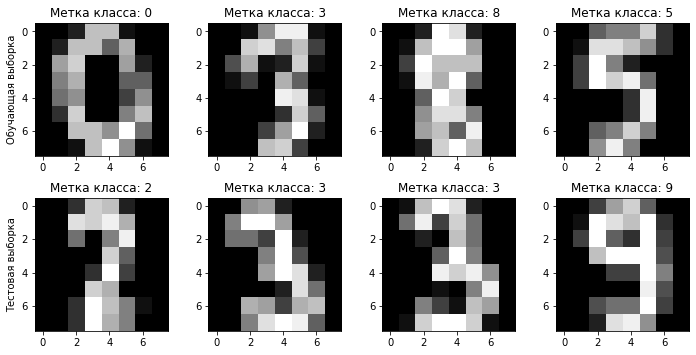

In [83]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ds in enumerate(((X_train, y_train), (X_test, y_test))):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds[0]), size=4)):
        image, label = ds[0][kdx], ds[1][kdx]
        axes[idx, jdx].imshow(image.reshape([8, 8]).numpy(), cmap='gray')
        axes[idx, jdx].set_title(f'Метка класса: {label}')
        
axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

fig.tight_layout()
plt.show()

## Обучение нейронной сети. [Кросспроверка. 2 балла]

Теперь всё готово к обучению нейронной сети. Для градиентной оптимизации в **Pytorch** реализовано множество оптимизаторов. В данном задании мы будем использовать оптимизатор **LBFGS** (класс `torch.optim.LBFGS`).

Большинство оптимизаторов в **Pytorch** отнаследовано от базового класса `torch.optim.Optimizer` и имеют следующий вид:
```python

class OptimizerExample(torch.optim.Optimizer):
    def __init__(self, params, **hyperparameters):
        '''
        Конструктор оптимизатора
        
        :param params: список или генератор обучаемых параметров модели
        :param hyperparameters: различные гиперпараметры оптимизатора, например, темп обучения
        '''
        super().__init__(params, hyperparameters)
    
        
    def step(self, closure=None):
        '''
        Функция, выполняющая шаг оптимизации, используя градиенты, сохранённые в тензорах self.params
        '''
        ...
        
    def zero_grad(self):
        '''
        Функция, очищающая градиенты, сохранённые в тензорах self.params
        '''
        ...
```

Отметим, что оптимизаторы в **Pytorch** обычно не управляют подсчётом градиентов, а лишь используют значения атрибута  `grad` у обучаемых параметров. Это позволяет разделить вычисление функции потерь, вычисление градиентов и сам шаг оптимизации на отдельные компоненты, что делает код более читаемым.

Большинство оптимизаторов поддерживают два способа использования:
1. Упрощённый способ, в котором метод `step` используется после того, как были посчитаны градиенты (например, через вызов `backward`)
2. Подвинутый способ, в котором подсчёт градиентов инкапсулирован в функцию `closure`, которая передаётся в метод `step` единственным параметром. Есть как минимум два аргумента в пользу такого варианта:
    * Такой подход позволяет явно выделить в коде отдельную функцию, которая считает градиенты модели, что улучшает читаемость кода
    * Некоторые оптимизаторы (например, реализующие алгоритмы LBFGS и Метод Сопряжённых Градиентов) требуют многократного подсчёта градиентов для выполнения одного шага оптимизации, что реализовано через выделение отдельной функции для подсчёта градиентов
    
Таким образом, функция `closure` выполняет следующие действия:
1. Отчищает градиенты обучаемых параметров, например, через вызов метода `zero_grad` у оптимизатора
2. Вычисляет функцию потерь и её градиент
3. Возвращает значение функции потерь
    
В данном задании предлагается воспользоваться оптимизатором **LBFGS**. Хотя на практике такой выбор не очень популярен из-за его больших требований по памяти, этот алгоритм устойчив к выбору темпа обучения, что позволит избавиться от подбора этого гиперпараметра в задании. Другой недостаток — данный метод требует вычисление полного градиента (то есть прохода по всей выборке), а не градиента по минибатчу. Это делает метод вычислительно трудозатратным, но с другой стороны избавляет от необходимости перебирать ещё один параметр — размер батча.

Создадим нейросеть, оптимизатор, а также класс-функцию потерь:

In [21]:
dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size, 
    n_classes=n_classes, n_layers=3, activation=ReLU
)

# По умолчанию, LBFGS может делать несколько шагов оптимизации внутри себя. 
#   Чтобы ограничить это поведение, установим параметр max_iter равным 1
optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)

loss_fn = CrossEntropyLoss()

In [22]:
dense_network, optimizer, loss_fn

(DenseNetwork(
   (layers): ModuleList(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ), LBFGS (
 Parameter Group 0
     history_size: 100
     line_search_fn: None
     lr: 1
     max_eval: 1
     max_iter: 1
     tolerance_change: 1e-09
     tolerance_grad: 1e-07
 ), CrossEntropyLoss())

Одно из основных преимуществ **Pytorch** — возможность использовать графический ускоритель, что уменьшает время вычислений на порядки. При этом, Pytorch позволяет писать код таким образом, чтобы он запускался на любых устройствах, будь то CPU, или GPU, или TPU/XML (device-agnostic код). Для этого в Pytorch реализован класс-обёртка `torch.device`, содержащий информацию об устройстве, на котором будут происходить вычисления:

In [23]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    
print(type(device), device)

<class 'torch.device'> cpu


Для переноса всех параметров модели на нужное устройство можно использовать метод `to`:

In [24]:
dense_network.to(device), next(iter(dense_network.parameters()))

(DenseNetwork(
   (layers): ModuleList(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ), Parameter containing:
 tensor([[-1.4947e-03,  4.2816e-04,  2.8447e-03,  ..., -2.1025e-02,
           9.0308e-04, -9.5066e-03],
         [-9.3269e-04, -5.1684e-03,  9.1144e-03,  ...,  2.0786e-03,
          -1.0325e-03, -1.2390e-02],
         [ 1.0276e-02, -3.0158e-02,  7.2866e-03,  ..., -1.1038e-02,
           6.0548e-03, -8.2766e-03],
         ...,
         [-3.5096e-04,  2.9038e-03,  2.1791e-02,  ..., -1.2235e-02,
           4.8217e-03,  1.7114e-03],
         [ 1.1644e-02,  6.4521e-04,  4.2486e-03,  ..., -1.2361e-02,
           1.3151e-03,  2.2870e-02],
         [-4.7960e-03,  1.4291e-03, -9.3541e-03,  ..., -8.2723e-05,
           7.8475e-04, -1.9784e-02]], requires_grad=True))

Теперь, осталось только реализовать цикл оптимизации и подсчёт метрик. 

**Везде выводите значения точности (accuracy) в процентах.**

Реализуйте цикл обучения модели в функции `training_loop`:

In [25]:
import tqdm.notebook as tqdm

def training_loop(n_epochs, network, loss_fn, optimizer, ds_train, ds_test, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param Tuple[torch.Tensor, torch.Tensor] ds_train: Признаки и метки истинного класса обучающей выборки
    :param Tuple[torch.Tensor, torch.Tensor] ds_test: Признаки и метки истинного класса тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    network.to(device)
    ds_train = (ds_train[0].to(device), ds_train[1].to(device))
    ds_test = (ds_test[0].to(device), ds_test[1].to(device))
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True):
        # Переводим сеть в режим обучения
        network.train()

        # Итерация обучения сети
        def closure():
            '''
            Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                1. Отчистка текущих градиентов
                2. Выполнение прямого прохода по сети в вычисление функции потерь
                3. Вычисление градиентов функции потерь
            :returns: Значение функции потерь
            '''
            ### your code here
            optimizer.zero_grad()
            loss = loss_fn(network(ds_train[0].float().to(device)), ds_train[1].to(device))
            loss.backward()
            return loss
        
        # Шаг оптимизации
        ### your code here
        optimizer.step(closure)
        # Переводим сеть в инференс режим
        ### your code here
        network.eval()
        # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
        #   для ускорения операций
        with torch.no_grad():
            # Вычисление качества и функции потерь на обучающей выборке
            ### your code here
            train_output = network(ds_train[0].float().to(device))
            train_losses.append(loss_fn(train_output, ds_train[1].to(device)))
            train_accuracies.append(torch.sum(torch.max(train_output, 1)[1] == ds_train[1].to(device)) / ds_train[1].shape[0] * 100)
            # Вычисление качества и функции потерь на тестовой выборке
            ### your code here
            test_output = network(ds_test[0].float().to(device))
            test_losses.append(loss_fn(test_output, ds_test[1].to(device)))
            test_accuracies.append(torch.sum(torch.max(test_output, 1)[1] == ds_test[1].to(device)) / ds_test[1].shape[0] * 100)
            if epoch % 20 == 0:
                print(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}'.format(
                        train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                    )
                )
            
    return train_losses, test_losses, train_accuracies, test_accuracies

Обучим сеть. Во всех экспериментах обучайте сеть $200$ эпох с параметром `max_iter=1` в оптимизаторе.

In [26]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=200, network=dense_network, loss_fn=loss_fn, 
    optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.84/9.33
Loss (Train/Test): 1.264/1.121. Accuracy, % (Train/Test): 56.50/63.56
Loss (Train/Test): 0.347/0.343. Accuracy, % (Train/Test): 89.24/88.22
Loss (Train/Test): 0.048/0.276. Accuracy, % (Train/Test): 98.74/94.22
Loss (Train/Test): 0.000/1.577. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/3.147. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.147. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.147. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.147. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.147. Accuracy, % (Train/Test): 100.00/94.44


Выведите итоговое качество и значение функции потерь на обучении (`X_train`, `y_train`) и на контроле (`X_test`, `y_test`):

In [27]:
### your code here
print('Final train loss: ', float(train_losses[-1]), sep='')
print('Final test loss: ', float(test_losses[-1]), sep='')
print('Final train accuracy: ', float(train_accs[-1]), ' %', sep='')
print('Final test accuracy: ', float(test_accs[-1]), ' %', sep='')

Final train loss: 3.5399935760516144e-10
Final test loss: 3.1465420722961426
Final train accuracy: 100.0 %
Final test accuracy: 94.44444274902344 %


Изобразим на графике кривую качества на обучении и контроле по итерациям:

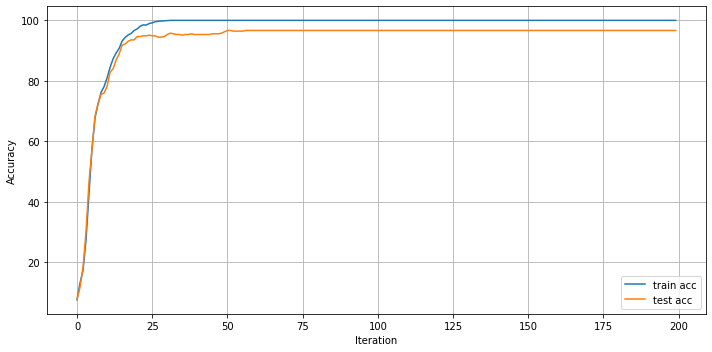

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="train acc")
ax.plot(test_accs, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

## Эксперименты с числом слоев. [Кросспроверка. 3 балла]

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучить нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны, то есть используются одинаковые гиперпараметры обучения).

In [117]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [118]:
### your code here
for i in range(5):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size, 
            n_classes=n_classes, n_layers=i+1, activation=ReLU
        )
        dense_network.to(device)
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()
        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn, 
            optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
        )
        accs_train[i,j] = train_accs[-1]
        accs_test[i,j] = test_accs[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.215/2.161. Accuracy, % (Train/Test): 24.28/27.78
Loss (Train/Test): 0.024/0.196. Accuracy, % (Train/Test): 99.48/95.11
Loss (Train/Test): 0.000/1.113. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.221/2.277. Accuracy, % (Train/Test): 16.56/13.33
Loss (Train/Test): 0.029/0.173. Accuracy, % (Train/Test): 99.41/95.56
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.458. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.035/2.023. Accuracy, % (Train/Test): 36.15/37.11
Loss (Train/Test): 0.026/0.273. Accuracy, % (Train/Test): 99.18/94.89
Loss (Train/Test): 0.000/1.161. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.601. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.165/2.148. Accuracy, % (Train/Test): 30.22/31.56
Loss (Train/Test): 0.033/0.203. Accuracy, % (Train/Test): 99.26/95.78
Loss (Train/Test): 0.000/0.989. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.294. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.140/2.164. Accuracy, % (Train/Test): 25.69/22.22
Loss (Train/Test): 0.031/0.173. Accuracy, % (Train/Test): 99.33/95.11
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.380. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.282/2.283. Accuracy, % (Train/Test): 40.01/39.33
Loss (Train/Test): 0.100/0.152. Accuracy, % (Train/Test): 97.03/95.78
Loss (Train/Test): 0.000/0.805. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.287/2.287. Accuracy, % (Train/Test): 27.47/32.44
Loss (Train/Test): 0.258/0.279. Accuracy, % (Train/Test): 92.80/92.44
Loss (Train/Test): 0.015/0.300. Accuracy, % (Train/Test): 99.78/95.56
Loss (Train/Test): 0.000/1.679. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.292/2.295. Accuracy, % (Train/Test): 11.95/9.11
Loss (Train/Test): 0.161/0.235. Accuracy, % (Train/Test): 95.25/92.44
Loss (Train/Test): 0.007/0.706. Accuracy, % (Train/Test): 99.70/95.56
Loss (Train/Test): 0.000/2.076. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.352. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.352. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.352. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.352. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.352. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.352. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.288/2.290. Accuracy, % (Train/Test): 27.62/25.56
Loss (Train/Test): 0.266/0.285. Accuracy, % (Train/Test): 92.50/89.33
Loss (Train/Test): 0.016/0.228. Accuracy, % (Train/Test): 99.70/96.44
Loss (Train/Test): 0.000/1.734. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/2.402. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/2.402. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/2.402. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/2.402. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/2.402. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/2.402. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.292/2.293. Accuracy, % (Train/Test): 26.95/26.22
Loss (Train/Test): 0.342/0.322. Accuracy, % (Train/Test): 89.68/91.56
Loss (Train/Test): 0.025/0.239. Accuracy, % (Train/Test): 99.41/95.33
Loss (Train/Test): 0.000/1.487. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.646. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.646. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.646. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.646. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.646. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.646. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.302. Accuracy, % (Train/Test): 13.21/9.56
Loss (Train/Test): 1.157/1.069. Accuracy, % (Train/Test): 63.99/66.22
Loss (Train/Test): 0.308/0.400. Accuracy, % (Train/Test): 89.53/88.44
Loss (Train/Test): 0.085/0.273. Accuracy, % (Train/Test): 97.92/93.33
Loss (Train/Test): 0.027/0.437. Accuracy, % (Train/Test): 99.26/93.56
Loss (Train/Test): 0.003/1.772. Accuracy, % (Train/Test): 99.93/92.89
Loss (Train/Test): 0.000/10.463. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/16.257. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/16.257. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/16.257. Accuracy, % (Train/Test): 100.00/93.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 17.00/13.56
Loss (Train/Test): 1.056/0.948. Accuracy, % (Train/Test): 66.37/71.56
Loss (Train/Test): 0.254/0.333. Accuracy, % (Train/Test): 92.06/88.89
Loss (Train/Test): 0.035/0.335. Accuracy, % (Train/Test): 98.89/93.78
Loss (Train/Test): 0.000/1.478. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/2.820. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.820. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.820. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.820. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.820. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 11.14/7.56
Loss (Train/Test): 0.935/0.937. Accuracy, % (Train/Test): 70.90/75.56
Loss (Train/Test): 0.290/0.336. Accuracy, % (Train/Test): 91.24/89.78
Loss (Train/Test): 0.088/0.293. Accuracy, % (Train/Test): 97.25/93.78
Loss (Train/Test): 0.015/0.619. Accuracy, % (Train/Test): 99.78/92.89
Loss (Train/Test): 0.003/1.488. Accuracy, % (Train/Test): 99.93/92.89
Loss (Train/Test): 0.000/8.041. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/10.567. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/10.567. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/10.567. Accuracy, % (Train/Test): 100.00/92.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 14.18/11.33
Loss (Train/Test): 0.739/0.719. Accuracy, % (Train/Test): 75.35/76.00
Loss (Train/Test): 0.138/0.220. Accuracy, % (Train/Test): 95.55/93.78
Loss (Train/Test): 0.006/0.647. Accuracy, % (Train/Test): 99.85/95.11
Loss (Train/Test): 0.000/3.874. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.882. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.882. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.882. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.882. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.882. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.92/10.44
Loss (Train/Test): 0.588/0.588. Accuracy, % (Train/Test): 80.92/81.78
Loss (Train/Test): 0.077/0.149. Accuracy, % (Train/Test): 97.10/94.44
Loss (Train/Test): 0.000/0.727. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.949. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.949. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.949. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.949. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.949. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.949. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 1.821/1.821. Accuracy, % (Train/Test): 37.56/34.22
Loss (Train/Test): 0.644/0.644. Accuracy, % (Train/Test): 75.35/76.44
Loss (Train/Test): 0.191/0.310. Accuracy, % (Train/Test): 93.10/89.56
Loss (Train/Test): 0.045/0.253. Accuracy, % (Train/Test): 98.89/96.22
Loss (Train/Test): 0.003/1.092. Accuracy, % (Train/Test): 99.93/94.00
Loss (Train/Test): 0.000/4.416. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/4.860. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/4.860. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/4.860. Accuracy, % (Train/Test): 100.00/93.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 1.630/1.593. Accuracy, % (Train/Test): 41.13/41.33
Loss (Train/Test): 0.784/0.702. Accuracy, % (Train/Test): 75.20/76.44
Loss (Train/Test): 0.346/0.424. Accuracy, % (Train/Test): 88.57/88.00
Loss (Train/Test): 0.115/0.344. Accuracy, % (Train/Test): 96.81/92.89
Loss (Train/Test): 0.029/0.415. Accuracy, % (Train/Test): 99.11/94.00
Loss (Train/Test): 0.002/1.631. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/4.890. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.636. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.636. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 1.551/1.547. Accuracy, % (Train/Test): 38.98/39.78
Loss (Train/Test): 0.704/0.696. Accuracy, % (Train/Test): 74.91/76.22
Loss (Train/Test): 0.176/0.297. Accuracy, % (Train/Test): 94.21/91.56
Loss (Train/Test): 0.007/0.603. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.000/2.038. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/3.217. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.217. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.217. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.217. Accuracy, % (Train/Test): 100.00/93.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.54/8.44
Loss (Train/Test): 1.197/1.189. Accuracy, % (Train/Test): 55.61/55.33
Loss (Train/Test): 0.233/0.251. Accuracy, % (Train/Test): 93.10/90.89
Loss (Train/Test): 0.053/0.276. Accuracy, % (Train/Test): 98.37/92.67
Loss (Train/Test): 0.004/0.724. Accuracy, % (Train/Test): 99.93/93.78
Loss (Train/Test): 0.000/3.087. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.116. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.116. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.116. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/3.116. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 13.73/10.67
Loss (Train/Test): 2.201/2.224. Accuracy, % (Train/Test): 21.01/16.89
Loss (Train/Test): 1.620/1.632. Accuracy, % (Train/Test): 34.15/36.89
Loss (Train/Test): 0.883/0.968. Accuracy, % (Train/Test): 62.51/63.56
Loss (Train/Test): 0.365/0.436. Accuracy, % (Train/Test): 87.45/87.11
Loss (Train/Test): 0.090/0.414. Accuracy, % (Train/Test): 97.10/93.33
Loss (Train/Test): 0.013/0.857. Accuracy, % (Train/Test): 99.63/93.56
Loss (Train/Test): 0.000/2.949. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/5.450. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/5.450. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.098/2.057. Accuracy, % (Train/Test): 22.87/24.00
Loss (Train/Test): 1.344/1.375. Accuracy, % (Train/Test): 46.10/43.33
Loss (Train/Test): 0.843/0.950. Accuracy, % (Train/Test): 67.04/66.22
Loss (Train/Test): 0.443/0.604. Accuracy, % (Train/Test): 85.89/83.11
Loss (Train/Test): 0.166/0.492. Accuracy, % (Train/Test): 95.10/90.67
Loss (Train/Test): 0.056/0.864. Accuracy, % (Train/Test): 98.29/92.44
Loss (Train/Test): 0.011/2.132. Accuracy, % (Train/Test): 99.48/92.22
Loss (Train/Test): 0.001/6.460. Accuracy, % (Train/Test): 100.00/91.33
Loss (Train/Test): 0.000/17.317. Accuracy, % (Train/Test): 100.00/91.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 12.370/12.249. Accuracy, % (Train/Test): 9.73/12.00
Loss (Train/Test): 2.147/2.159. Accuracy, % (Train/Test): 25.98/22.00
Loss (Train/Test): 1.690/1.678. Accuracy, % (Train/Test): 28.95/30.67
Loss (Train/Test): 1.057/1.091. Accuracy, % (Train/Test): 61.92/61.33
Loss (Train/Test): 0.728/0.736. Accuracy, % (Train/Test): 74.31/75.56
Loss (Train/Test): 0.505/0.538. Accuracy, % (Train/Test): 81.51/82.00
Loss (Train/Test): 0.339/0.472. Accuracy, % (Train/Test): 88.72/86.00
Loss (Train/Test): 0.213/0.454. Accuracy, % (Train/Test): 93.10/88.44
Loss (Train/Test): 0.126/0.480. Accuracy, % (Train/Test): 96.29/89.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.294/2.301. Accuracy, % (Train/Test): 11.88/9.78
Loss (Train/Test): 1.738/1.700. Accuracy, % (Train/Test): 35.78/34.44
Loss (Train/Test): 0.761/0.765. Accuracy, % (Train/Test): 71.57/71.78
Loss (Train/Test): 0.353/0.403. Accuracy, % (Train/Test): 87.68/87.78
Loss (Train/Test): 0.169/0.339. Accuracy, % (Train/Test): 94.21/90.44
Loss (Train/Test): 0.069/0.367. Accuracy, % (Train/Test): 97.77/92.22
Loss (Train/Test): 0.015/0.874. Accuracy, % (Train/Test): 99.63/94.00
Loss (Train/Test): 0.001/2.981. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/9.184. Accuracy, % (Train/Test): 100.00/93.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.056/2.030. Accuracy, % (Train/Test): 20.04/22.00
Loss (Train/Test): 1.293/1.258. Accuracy, % (Train/Test): 50.63/53.78
Loss (Train/Test): 0.575/0.579. Accuracy, % (Train/Test): 78.62/77.11
Loss (Train/Test): 0.280/0.418. Accuracy, % (Train/Test): 89.68/88.44
Loss (Train/Test): 0.070/0.508. Accuracy, % (Train/Test): 98.29/91.11
Loss (Train/Test): 0.015/1.253. Accuracy, % (Train/Test): 99.63/92.00
Loss (Train/Test): 0.000/4.624. Accuracy, % (Train/Test): 100.00/90.89
Loss (Train/Test): 0.000/12.656. Accuracy, % (Train/Test): 100.00/91.11
Loss (Train/Test): 0.000/12.656. Accuracy, % (Train/Test): 100.00/91.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 3.872/3.973. Accuracy, % (Train/Test): 19.52/16.22
Loss (Train/Test): 1.161/1.089. Accuracy, % (Train/Test): 58.13/62.44
Loss (Train/Test): 0.672/0.658. Accuracy, % (Train/Test): 78.10/77.11
Loss (Train/Test): 0.371/0.428. Accuracy, % (Train/Test): 88.27/86.89
Loss (Train/Test): 0.182/0.234. Accuracy, % (Train/Test): 94.43/92.44
Loss (Train/Test): 0.092/0.201. Accuracy, % (Train/Test): 97.40/93.78
Loss (Train/Test): 0.032/0.397. Accuracy, % (Train/Test): 99.18/93.56
Loss (Train/Test): 0.004/1.299. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/3.707. Accuracy, % (Train/Test): 100.00/92.67


Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

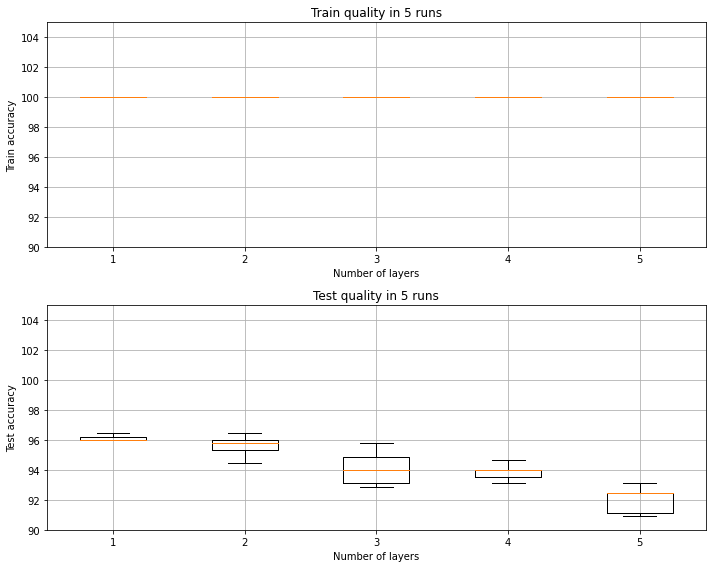

In [119]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_ylim(90, 105)
axes[1].set_ylim(90, 105)

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
1. Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
2. Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

__Ответы:__ 

На обучении качество максимальное для разного количества слоев.
На тесте качество зависит от инициализации весов.
На тесте среднее качество хуже у сети с 5 слоями.
Наибольший разброс у сети с 3 и 5 слоями.
Наименьший разброс у сети с 1 слоем.

У сети с 1 слоем меньше всего параметров инициализации, которые влияют на точность, поэтому она показала себя лучше остальных по совокупности критериев.
Из этого можно сделать вывод, что линейная модель дает лучшее качество, нежели нелинейная модель.

## Эксперименты c различными инициализациями весов. [Кросспроверка. 3 балла]

Как уже было сказано, начальная инициализация весов нейронной сети может сильно влиять на процесс ее обучения и, как следствие, на ее качество.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными инициализациями слоев.

Для этого необходимо реализовать функцию, инициализирующую веса линейных слоёв нашей нейронной сети. Для этого воспользуемся методом [`apply`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply), определённым у класса `torch.nn.Module`. Данный метод позволяет рекурсивно применить пользовательскую функцию ко всем подмодулям данного модуля.

Реализуйте функцию `initialize_module`. Добавьте в её функционал возможность инициализировать веса сеть с помощью:
1. **Инициализации Kaiming** (используется, если в нейронной сети в качестве функций активации используется ReLU) 
2. **Инициализации Xavier** (используется, если в нейронной сети в качестве функций активации используется Tanh или Sigmoid)
3. **Инициализации нормальным распределением** с нулевым средним и заданной дисперсией

**Замечание:** метод `apply` применяется рекурсивно ко всем модулям. Чтобы инициализировать линейные слои нужно проверять, является ли данный модуль инстансом класса `Linear`. Можете использовать встроенный метод `isinstance` для такой проверки. 

In [84]:
def initialize_module(module, init):
    '''
    Инициализация линейного модуля с заданными параметрами
    :param torch.nn.Module module: Модуль, который нужно инициализировать
    :param Union[str, float] init: В зависимости от значения, выполняется инициализация матрицы весов:
        * init == 'Kaiming': инициализация Kaiming
        * init == 'Xavier': инициализация Xavier
        * isinstance(init, float): инициализация из нормального распределения со стандартным отклонением init
        Вектор смещения всегда инициализируется нулями
        
    '''
    if isinstance(module, Linear):
        if init == 'Kaiming':
            torch.nn.init.kaiming_normal(module.weight)
        elif init == 'Xavier':
            torch.nn.init.xavier_normal_(module.weight)
        elif isinstance(init, float):
            torch.nn.init.normal_(module.weight, std=init)
        torch.nn.init.constant_(module.bias, 0)

Теперь попробуйте для каждой из $3$ инициализаций обучить нейронную сеть несколько раз. Попробуйте проделать данную операцию при зафиксированном числе слоев равным $3$, $4$ и $5$.

### 3 слоя

Зафиксируйте в сети число слоев равное трём.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с инициализацией Kaiming при $i = 3$, с инициализацией Xavier при $i = 4$ и с инициализацией из нормального распределения с фиксированными параметрами при $0 \leqslant i \leqslant 2$ (попробуйте здесь $3$ разных параметра для стандартного отклонения для нормального распределения, например: `1e-3`, `1e-2`, `1e-1`). Заметьте, что при большом числе слоев слишком низкое стандартное отклонение может не давать нейронной сети нормально обучиться.

In [85]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [86]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [87]:
from functools import partial

In [88]:
### your code here
for i in range(len(init_vars)):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size, 
            n_classes=n_classes, n_layers=3, activation=ReLU
        )
        dense_network.to(device)
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()
        init_m = partial(initialize_module, init=init_vars[i])
        dense_network.apply(init_m)
        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn, 
            optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
        )
        accs_train[i,j] = train_accs[-1]
        accs_test[i,j] = test_accs[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.91/8.22
Loss (Train/Test): 1.434/1.354. Accuracy, % (Train/Test): 51.00/51.56
Loss (Train/Test): 0.574/0.527. Accuracy, % (Train/Test): 81.22/82.67
Loss (Train/Test): 0.138/0.212. Accuracy, % (Train/Test): 95.69/93.33
Loss (Train/Test): 0.010/0.808. Accuracy, % (Train/Test): 99.63/94.67
Loss (Train/Test): 0.000/4.395. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/5.881. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.881. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.881. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.881. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.286/2.293. Accuracy, % (Train/Test): 20.42/15.78
Loss (Train/Test): 0.679/0.664. Accuracy, % (Train/Test): 79.44/79.78
Loss (Train/Test): 0.179/0.255. Accuracy, % (Train/Test): 94.51/92.00
Loss (Train/Test): 0.022/0.451. Accuracy, % (Train/Test): 99.26/94.67
Loss (Train/Test): 0.000/1.757. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/2.962. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/2.962. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/2.962. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/2.962. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.99/10.00
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 18.19/13.78
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 17.97/14.00
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 17.97/13.78
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 18.34/14.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 18.86/14.44
Loss (Train/Test): 2.298/2.304. Accuracy, % (Train/Test): 25.24/20.22
Loss (Train/Test): 1.399/1.393. Accuracy, % (Train/Test): 49.07/49.78
Loss (Train/Test): 0.239/0.271. Accuracy, % (Train/Test): 92.06/92.22
Loss (Train/Test): 0.037/0.264. Accuracy, % (Train/Test): 99.03/93.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.10/8.44
Loss (Train/Test): 0.854/0.826. Accuracy, % (Train/Test): 73.65/74.22
Loss (Train/Test): 0.243/0.338. Accuracy, % (Train/Test): 92.50/89.78
Loss (Train/Test): 0.031/0.289. Accuracy, % (Train/Test): 99.33/94.67
Loss (Train/Test): 0.000/2.297. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.320. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.320. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.320. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.320. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.320. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 15.07/10.89
Loss (Train/Test): 1.139/1.149. Accuracy, % (Train/Test): 65.63/68.22
Loss (Train/Test): 0.194/0.265. Accuracy, % (Train/Test): 93.62/91.33
Loss (Train/Test): 0.002/0.558. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/2.230. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.230. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.230. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.230. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.230. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.230. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.10/9.11
Loss (Train/Test): 0.494/0.477. Accuracy, % (Train/Test): 85.82/86.22
Loss (Train/Test): 0.057/0.259. Accuracy, % (Train/Test): 98.74/94.22
Loss (Train/Test): 0.000/1.324. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/2.782. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.782. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.782. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.782. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.782. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.782. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 1.017/0.908. Accuracy, % (Train/Test): 67.33/70.22
Loss (Train/Test): 0.221/0.273. Accuracy, % (Train/Test): 93.32/91.11
Loss (Train/Test): 0.050/0.281. Accuracy, % (Train/Test): 98.89/95.11
Loss (Train/Test): 0.004/0.890. Accuracy, % (Train/Test): 99.93/94.89
Loss (Train/Test): 0.000/3.772. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/4.763. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/4.763. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/4.763. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/4.763. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 13.88/10.44
Loss (Train/Test): 0.816/0.811. Accuracy, % (Train/Test): 75.13/76.44
Loss (Train/Test): 0.116/0.171. Accuracy, % (Train/Test): 96.36/92.89
Loss (Train/Test): 0.003/0.636. Accuracy, % (Train/Test): 99.93/93.56
Loss (Train/Test): 0.000/2.105. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.134. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.134. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.134. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.134. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.134. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.265/2.297. Accuracy, % (Train/Test): 11.21/9.11
Loss (Train/Test): 2.101/2.162. Accuracy, % (Train/Test): 32.00/26.22
Loss (Train/Test): 1.579/1.629. Accuracy, % (Train/Test): 50.63/48.89
Loss (Train/Test): 0.562/0.533. Accuracy, % (Train/Test): 83.37/84.22
Loss (Train/Test): 0.097/0.160. Accuracy, % (Train/Test): 96.73/95.11
Loss (Train/Test): 0.007/0.458. Accuracy, % (Train/Test): 99.85/95.78
Loss (Train/Test): 0.000/1.919. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.245. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.245. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 11.58/10.00
Loss (Train/Test): 0.964/0.866. Accuracy, % (Train/Test): 68.45/70.67
Loss (Train/Test): 0.130/0.231. Accuracy, % (Train/Test): 95.47/93.56
Loss (Train/Test): 0.005/0.650. Accuracy, % (Train/Test): 99.85/95.56
Loss (Train/Test): 0.000/2.060. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.301. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.301. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.301. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.301. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.301. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.771/2.843. Accuracy, % (Train/Test): 9.80/8.22
Loss (Train/Test): 0.156/0.171. Accuracy, % (Train/Test): 94.88/94.67
Loss (Train/Test): 0.005/0.418. Accuracy, % (Train/Test): 99.85/96.00
Loss (Train/Test): 0.000/1.766. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.099. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.099. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.099. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.099. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.099. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/2.099. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.483/2.496. Accuracy, % (Train/Test): 9.21/7.33
Loss (Train/Test): 0.151/0.203. Accuracy, % (Train/Test): 94.88/92.44
Loss (Train/Test): 0.009/0.350. Accuracy, % (Train/Test): 99.93/96.00
Loss (Train/Test): 0.000/0.934. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.483. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.483. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.483. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.483. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.483. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.483. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.691/2.674. Accuracy, % (Train/Test): 10.02/10.44
Loss (Train/Test): 0.197/0.253. Accuracy, % (Train/Test): 93.99/92.44
Loss (Train/Test): 0.005/0.388. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.318. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.534. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.534. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.534. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.534. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.534. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.534. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.593/2.661. Accuracy, % (Train/Test): 11.80/10.67
Loss (Train/Test): 0.195/0.248. Accuracy, % (Train/Test): 94.06/90.67
Loss (Train/Test): 0.011/0.246. Accuracy, % (Train/Test): 99.85/96.00
Loss (Train/Test): 0.000/0.807. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.054. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.054. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.054. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.054. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.054. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.054. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.351/2.371. Accuracy, % (Train/Test): 11.80/9.11
Loss (Train/Test): 0.174/0.207. Accuracy, % (Train/Test): 94.88/92.89
Loss (Train/Test): 0.002/0.404. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.800. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.878. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.878. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.878. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.878. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.878. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.878. Accuracy, % (Train/Test): 100.00/94.89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 42.814/44.184. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 0.233/0.418. Accuracy, % (Train/Test): 92.80/87.11
Loss (Train/Test): 0.006/0.222. Accuracy, % (Train/Test): 99.93/95.56
Loss (Train/Test): 0.000/0.440. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.538. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.538. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.538. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.538. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.538. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.538. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 27.508/28.847. Accuracy, % (Train/Test): 2.15/2.22
Loss (Train/Test): 0.398/0.545. Accuracy, % (Train/Test): 87.01/85.78
Loss (Train/Test): 0.054/0.567. Accuracy, % (Train/Test): 98.37/92.67
Loss (Train/Test): 0.006/0.682. Accuracy, % (Train/Test): 99.63/94.00
Loss (Train/Test): 0.001/0.959. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.001/1.398. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/2.424. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/4.047. Accuracy, % (Train/Test): 100.00/92.67
Loss (Train/Test): 0.000/4.746. Accuracy, % (Train/Test): 100.00/92.67
Loss (Train/Test): 0.000/4.746. Accuracy, % (Train/Test): 100.00/92.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 42.126/44.062. Accuracy, % (Train/Test): 9.43/8.44
Loss (Train/Test): 0.132/0.271. Accuracy, % (Train/Test): 95.99/92.67
Loss (Train/Test): 0.001/0.257. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.464. Accuracy, % (Train/Test): 100.00/96.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 35.788/35.972. Accuracy, % (Train/Test): 7.94/10.00
Loss (Train/Test): 0.257/0.403. Accuracy, % (Train/Test): 92.50/88.44
Loss (Train/Test): 0.002/0.346. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 57.918/58.406. Accuracy, % (Train/Test): 9.21/10.89
Loss (Train/Test): 0.214/0.410. Accuracy, % (Train/Test): 92.87/89.11
Loss (Train/Test): 0.001/0.189. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.366. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 5.514/5.541. Accuracy, % (Train/Test): 13.29/13.78
Loss (Train/Test): 0.101/0.231. Accuracy, % (Train/Test): 96.59/93.56
Loss (Train/Test): 0.000/0.398. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.333. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.329/7.213. Accuracy, % (Train/Test): 13.66/10.89
Loss (Train/Test): 0.111/0.178. Accuracy, % (Train/Test): 96.59/94.89
Loss (Train/Test): 0.001/0.277. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.890. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.192/7.470. Accuracy, % (Train/Test): 12.25/9.11
Loss (Train/Test): 0.129/0.175. Accuracy, % (Train/Test): 96.07/94.89
Loss (Train/Test): 0.001/0.280. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.920. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.905/5.009. Accuracy, % (Train/Test): 7.80/6.22
Loss (Train/Test): 0.091/0.215. Accuracy, % (Train/Test): 97.55/94.00
Loss (Train/Test): 0.000/0.345. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.962. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 8.699/9.044. Accuracy, % (Train/Test): 7.42/8.89
Loss (Train/Test): 0.141/0.208. Accuracy, % (Train/Test): 95.69/91.78
Loss (Train/Test): 0.001/0.361. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.027. Accuracy, % (Train/Test): 100.00/96.22


Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

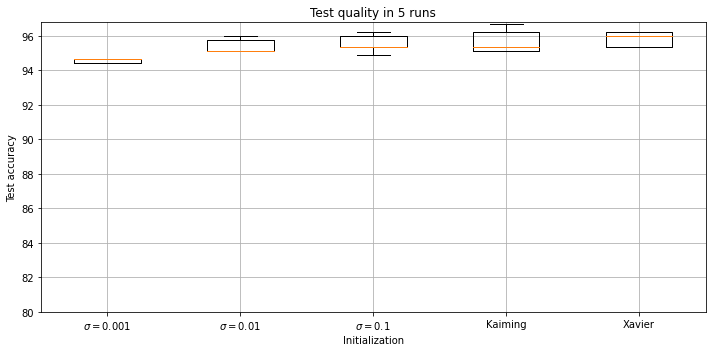

In [89]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

### 4 слоя

Выполните тут тот же код, что и в предыдущем пункте, но только уже с $4$ слоями в сети.

In [90]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [91]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [92]:
### your code here
for i in range(len(init_vars)):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size, 
            n_classes=n_classes, n_layers=4, activation=ReLU
        )
        dense_network.to(device)
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()
        init_m = partial(initialize_module, init=init_vars[i])
        dense_network.apply(init_m)
        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn, 
            optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
        )
        accs_train[i,j] = train_accs[-1]
        accs_test[i,j] = test_accs[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.281/2.290. Accuracy, % (Train/Test): 21.16/16.67
Loss (Train/Test): 2.192/2.207. Accuracy, % (Train/Test): 20.79/16.44
Loss (Train/Test): 1.498/1.498. Accuracy, % (Train/Test): 46.18/47.56
Loss (Train/Test): 0.724/0.702. Accuracy, % (Train/Test): 75.72/76.22
Loss (Train/Test): 0.302/0.324. Accuracy, % (Train/Test): 89.38/89.56
Loss (Train/Test): 0.089/0.243. Accuracy, % (Train/Test): 97.03/94.22
Loss (Train/Test): 0.006/0.738. Accuracy, % (Train/Test): 99.85/94.89
Loss (Train/Test): 0.000/3.366. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/3.846. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 9.80/7.56
Loss (Train/Test): 2.260/2.266. Accuracy, % (Train/Test): 23.31/19.78
Loss (Train/Test): 1.538/1.539. Accuracy, % (Train/Test): 41.95/41.56
Loss (Train/Test): 0.680/0.635. Accuracy, % (Train/Test): 79.14/80.89
Loss (Train/Test): 0.164/0.408. Accuracy, % (Train/Test): 94.73/89.33
Loss (Train/Test): 0.023/0.829. Accuracy, % (Train/Test): 99.33/92.44
Loss (Train/Test): 0.000/3.587. Accuracy, % (Train/Test): 100.00/92.22
Loss (Train/Test): 0.000/6.298. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/6.298. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/6.298. Accuracy, % (Train/Test): 100.00/93.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 1.853/1.835. Accuracy, % (Train/Test): 24.28/28.22
Loss (Train/Test): 1.124/1.148. Accuracy, % (Train/Test): 60.73/62.22
Loss (Train/Test): 0.397/0.451. Accuracy, % (Train/Test): 87.45/85.56
Loss (Train/Test): 0.119/0.359. Accuracy, % (Train/Test): 95.99/91.33
Loss (Train/Test): 0.029/0.598. Accuracy, % (Train/Test): 99.03/93.33
Loss (Train/Test): 0.001/2.104. Accuracy, % (Train/Test): 100.00/92.44
Loss (Train/Test): 0.000/5.496. Accuracy, % (Train/Test): 100.00/92.00
Loss (Train/Test): 0.000/7.403. Accuracy, % (Train/Test): 100.00/91.78
Loss (Train/Test): 0.000/7.403. Accuracy, % (Train/Test): 100.00/91.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 7.230/7.018. Accuracy, % (Train/Test): 26.28/30.89
Loss (Train/Test): 0.867/0.812. Accuracy, % (Train/Test): 71.42/72.67
Loss (Train/Test): 0.224/0.321. Accuracy, % (Train/Test): 92.95/89.78
Loss (Train/Test): 0.049/0.437. Accuracy, % (Train/Test): 98.66/93.56
Loss (Train/Test): 0.011/0.945. Accuracy, % (Train/Test): 99.63/92.89
Loss (Train/Test): 0.000/2.442. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/3.842. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/3.842. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/3.842. Accuracy, % (Train/Test): 100.00/93.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 9.65/7.78
Loss (Train/Test): 1.380/1.455. Accuracy, % (Train/Test): 51.22/49.33
Loss (Train/Test): 0.399/0.453. Accuracy, % (Train/Test): 85.75/85.33
Loss (Train/Test): 0.107/0.228. Accuracy, % (Train/Test): 96.29/94.67
Loss (Train/Test): 0.011/0.755. Accuracy, % (Train/Test): 99.70/93.56
Loss (Train/Test): 0.000/3.305. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/6.042. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/6.042. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/6.042. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/6.042. Accuracy, % (Train/Test): 100.00/93.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.387/2.406. Accuracy, % (Train/Test): 11.58/10.22
Loss (Train/Test): 0.565/0.527. Accuracy, % (Train/Test): 83.67/83.33
Loss (Train/Test): 0.091/0.284. Accuracy, % (Train/Test): 97.03/94.00
Loss (Train/Test): 0.004/0.582. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/2.100. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.164. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/3.164. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/3.164. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/3.164. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/3.164. Accuracy, % (Train/Test): 100.00/94.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.323/2.345. Accuracy, % (Train/Test): 13.96/14.89
Loss (Train/Test): 0.343/0.364. Accuracy, % (Train/Test): 88.86/86.00
Loss (Train/Test): 0.022/0.216. Accuracy, % (Train/Test): 99.41/95.56
Loss (Train/Test): 0.000/1.125. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.512. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.512. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.512. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.512. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.512. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.512. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.325/2.293. Accuracy, % (Train/Test): 17.97/22.00
Loss (Train/Test): 0.305/0.304. Accuracy, % (Train/Test): 89.46/90.67
Loss (Train/Test): 0.031/0.254. Accuracy, % (Train/Test): 99.33/94.44
Loss (Train/Test): 0.000/1.237. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/1.984. Accuracy, % (Train/Test): 100.00/92.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.274/2.246. Accuracy, % (Train/Test): 11.73/13.33
Loss (Train/Test): 0.385/0.360. Accuracy, % (Train/Test): 88.27/88.89
Loss (Train/Test): 0.055/0.213. Accuracy, % (Train/Test): 98.37/95.11
Loss (Train/Test): 0.000/0.665. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.324. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.324. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.324. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.324. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.324. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.324. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.315/2.310. Accuracy, % (Train/Test): 9.13/7.78
Loss (Train/Test): 0.325/0.297. Accuracy, % (Train/Test): 90.57/92.00
Loss (Train/Test): 0.048/0.195. Accuracy, % (Train/Test): 98.52/95.11
Loss (Train/Test): 0.001/0.645. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.014. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.272. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.272. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.272. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.272. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.272. Accuracy, % (Train/Test): 100.00/95.78


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 26.659/24.683. Accuracy, % (Train/Test): 9.06/12.22
Loss (Train/Test): 0.241/0.374. Accuracy, % (Train/Test): 92.87/90.22
Loss (Train/Test): 0.006/0.328. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.000/0.577. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.874. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.874. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.874. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.874. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.874. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.874. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 44.101/44.752. Accuracy, % (Train/Test): 10.17/9.78
Loss (Train/Test): 0.334/0.480. Accuracy, % (Train/Test): 90.42/86.44
Loss (Train/Test): 0.009/0.260. Accuracy, % (Train/Test): 99.93/93.78
Loss (Train/Test): 0.000/0.411. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.508. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.508. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.508. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.508. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.508. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.508. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 38.329/37.160. Accuracy, % (Train/Test): 10.47/11.78
Loss (Train/Test): 0.572/0.721. Accuracy, % (Train/Test): 83.30/80.89
Loss (Train/Test): 0.026/0.306. Accuracy, % (Train/Test): 99.18/92.22
Loss (Train/Test): 0.000/0.321. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.510. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.510. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.510. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.510. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.510. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.510. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 24.054/23.713. Accuracy, % (Train/Test): 7.50/7.56
Loss (Train/Test): 0.314/0.503. Accuracy, % (Train/Test): 90.05/84.22
Loss (Train/Test): 0.009/0.454. Accuracy, % (Train/Test): 99.93/93.33
Loss (Train/Test): 0.000/0.711. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.893. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.893. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.893. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.893. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.893. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.893. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 36.028/37.167. Accuracy, % (Train/Test): 13.59/14.67
Loss (Train/Test): 0.399/0.568. Accuracy, % (Train/Test): 87.01/82.67
Loss (Train/Test): 0.012/0.224. Accuracy, % (Train/Test): 99.85/94.67
Loss (Train/Test): 0.000/0.509. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.746. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.746. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.746. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.746. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.746. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.746. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.448/7.013. Accuracy, % (Train/Test): 13.29/13.11
Loss (Train/Test): 0.162/0.265. Accuracy, % (Train/Test): 94.73/91.11
Loss (Train/Test): 0.001/0.322. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/0.743. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.307/6.834. Accuracy, % (Train/Test): 9.80/10.89
Loss (Train/Test): 0.269/0.358. Accuracy, % (Train/Test): 91.76/88.67
Loss (Train/Test): 0.012/0.192. Accuracy, % (Train/Test): 99.63/95.56
Loss (Train/Test): 0.000/0.585. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.012. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.012. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.012. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.012. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.012. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.012. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 8.887/9.062. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 0.148/0.231. Accuracy, % (Train/Test): 95.47/92.44
Loss (Train/Test): 0.001/0.259. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.827. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.845. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.845. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.845. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.845. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.845. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.845. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 6.553/6.638. Accuracy, % (Train/Test): 12.03/10.22
Loss (Train/Test): 0.190/0.257. Accuracy, % (Train/Test): 94.36/91.78
Loss (Train/Test): 0.007/0.285. Accuracy, % (Train/Test): 99.93/95.56
Loss (Train/Test): 0.000/1.303. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.469. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.469. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.469. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.469. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.469. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.469. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.296/4.335. Accuracy, % (Train/Test): 16.11/14.00
Loss (Train/Test): 0.142/0.205. Accuracy, % (Train/Test): 95.84/94.00
Loss (Train/Test): 0.002/0.323. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.958. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.140. Accuracy, % (Train/Test): 100.00/95.11


Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

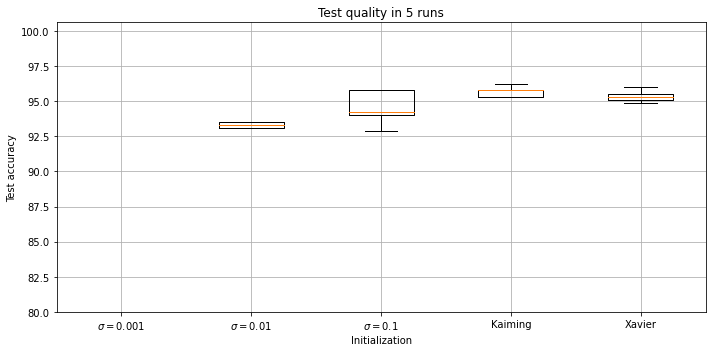

In [93]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

### 5 слоев

Выполните тут тот же код, что и в предыдущем пункте, но только уже с $5$ слоями в сети.

In [94]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [95]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [96]:
### your code here
for i in range(len(init_vars)):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size, 
            n_classes=n_classes, n_layers=5, activation=ReLU
        )
        dense_network.to(device)
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()
        init_m = partial(initialize_module, init=init_vars[i])
        dense_network.apply(init_m)
        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn, 
            optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
        )
        accs_train[i,j] = train_accs[-1]
        accs_test[i,j] = test_accs[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.148/2.148. Accuracy, % (Train/Test): 24.13/24.00
Loss (Train/Test): 1.409/1.380. Accuracy, % (Train/Test): 40.83/44.67
Loss (Train/Test): 0.704/0.670. Accuracy, % (Train/Test): 74.31/74.22
Loss (Train/Test): 0.233/0.280. Accuracy, % (Train/Test): 91.39/90.67
Loss (Train/Test): 0.056/0.352. Accuracy, % (Train/Test): 98.52/92.44
Loss (Train/Test): 0.001/1.839. Accuracy, % (Train/Test): 100.00/92.44
Loss (Train/Test): 0.000/7.022. Accuracy, % (Train/Test): 100.00/92.67
Loss (Train/Test): 0.000/6.845. Accuracy, % (Train/Test): 100.00/92.22
Loss (Train/Test): 0.000/6.845. Accuracy, % (Train/Test): 100.00/92.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.280/2.275. Accuracy, % (Train/Test): 12.18/13.11
Loss (Train/Test): 1.710/1.670. Accuracy, % (Train/Test): 26.13/28.89
Loss (Train/Test): 0.818/0.744. Accuracy, % (Train/Test): 71.34/74.67
Loss (Train/Test): 0.357/0.422. Accuracy, % (Train/Test): 88.49/86.22
Loss (Train/Test): 0.161/0.331. Accuracy, % (Train/Test): 94.43/89.33
Loss (Train/Test): 0.068/0.363. Accuracy, % (Train/Test): 98.00/91.33
Loss (Train/Test): 0.024/0.729. Accuracy, % (Train/Test): 99.18/90.22
Loss (Train/Test): 0.006/1.327. Accuracy, % (Train/Test): 99.93/90.67
Loss (Train/Test): 0.000/3.471. Accuracy, % (Train/Test): 100.00/89.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.147/2.132. Accuracy, % (Train/Test): 21.01/21.56
Loss (Train/Test): 1.554/1.504. Accuracy, % (Train/Test): 47.36/52.00
Loss (Train/Test): 0.886/0.825. Accuracy, % (Train/Test): 69.27/71.11
Loss (Train/Test): 0.519/0.534. Accuracy, % (Train/Test): 84.93/84.67
Loss (Train/Test): 0.271/0.354. Accuracy, % (Train/Test): 90.72/90.89
Loss (Train/Test): 0.141/0.326. Accuracy, % (Train/Test): 95.17/93.56
Loss (Train/Test): 0.069/0.418. Accuracy, % (Train/Test): 97.70/92.89
Loss (Train/Test): 0.027/0.879. Accuracy, % (Train/Test): 99.18/91.33
Loss (Train/Test): 0.009/2.772. Accuracy, % (Train/Test): 99.70/91.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.300/2.307. Accuracy, % (Train/Test): 19.75/15.78
Loss (Train/Test): 1.852/1.870. Accuracy, % (Train/Test): 22.87/22.00
Loss (Train/Test): 1.010/0.943. Accuracy, % (Train/Test): 62.66/64.00
Loss (Train/Test): 0.602/0.598. Accuracy, % (Train/Test): 78.40/80.44
Loss (Train/Test): 0.385/0.458. Accuracy, % (Train/Test): 85.82/85.78
Loss (Train/Test): 0.227/0.413. Accuracy, % (Train/Test): 93.10/89.56
Loss (Train/Test): 0.126/0.418. Accuracy, % (Train/Test): 95.92/91.78
Loss (Train/Test): 0.068/0.586. Accuracy, % (Train/Test): 97.92/92.00
Loss (Train/Test): 0.030/1.418. Accuracy, % (Train/Test): 99.03/91.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.290/2.301. Accuracy, % (Train/Test): 9.65/8.67
Loss (Train/Test): 1.957/1.917. Accuracy, % (Train/Test): 24.35/22.00
Loss (Train/Test): 1.173/1.088. Accuracy, % (Train/Test): 59.61/62.44
Loss (Train/Test): 0.581/0.565. Accuracy, % (Train/Test): 80.99/82.44
Loss (Train/Test): 0.338/0.376. Accuracy, % (Train/Test): 88.49/88.89
Loss (Train/Test): 0.178/0.353. Accuracy, % (Train/Test): 93.99/90.67
Loss (Train/Test): 0.101/0.299. Accuracy, % (Train/Test): 96.73/92.67
Loss (Train/Test): 0.060/0.305. Accuracy, % (Train/Test): 98.07/93.78
Loss (Train/Test): 0.034/0.458. Accuracy, % (Train/Test): 99.18/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.296/2.304. Accuracy, % (Train/Test): 8.24/7.33
Loss (Train/Test): 1.265/1.223. Accuracy, % (Train/Test): 44.54/45.33
Loss (Train/Test): 0.236/0.326. Accuracy, % (Train/Test): 91.24/88.67
Loss (Train/Test): 0.067/0.339. Accuracy, % (Train/Test): 97.70/93.56
Loss (Train/Test): 0.017/1.026. Accuracy, % (Train/Test): 99.55/93.78
Loss (Train/Test): 0.000/2.082. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/3.898. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/4.090. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/4.090. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/4.090. Accuracy, % (Train/Test): 100.00/93.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.304/2.300. Accuracy, % (Train/Test): 10.39/10.44
Loss (Train/Test): 1.039/1.062. Accuracy, % (Train/Test): 64.44/62.44
Loss (Train/Test): 0.266/0.369. Accuracy, % (Train/Test): 90.57/87.78
Loss (Train/Test): 0.050/0.324. Accuracy, % (Train/Test): 98.59/93.33
Loss (Train/Test): 0.001/1.280. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/3.123. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/3.908. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/3.908. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/3.908. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/3.908. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.311/2.309. Accuracy, % (Train/Test): 14.55/17.56
Loss (Train/Test): 0.662/0.656. Accuracy, % (Train/Test): 78.77/78.44
Loss (Train/Test): 0.126/0.216. Accuracy, % (Train/Test): 96.14/92.67
Loss (Train/Test): 0.025/0.281. Accuracy, % (Train/Test): 99.18/94.89
Loss (Train/Test): 0.002/1.229. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/2.472. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/3.966. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/4.154. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/4.154. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/4.154. Accuracy, % (Train/Test): 100.00/93.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.304/2.302. Accuracy, % (Train/Test): 2.45/2.44
Loss (Train/Test): 1.826/1.822. Accuracy, % (Train/Test): 31.11/35.78
Loss (Train/Test): 0.677/0.692. Accuracy, % (Train/Test): 79.96/80.22
Loss (Train/Test): 0.119/0.244. Accuracy, % (Train/Test): 95.92/92.44
Loss (Train/Test): 0.011/0.501. Accuracy, % (Train/Test): 99.85/94.00
Loss (Train/Test): 0.000/2.040. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/4.063. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/4.063. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/4.063. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/4.063. Accuracy, % (Train/Test): 100.00/94.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.319/2.310. Accuracy, % (Train/Test): 9.28/11.56
Loss (Train/Test): 1.009/1.057. Accuracy, % (Train/Test): 69.86/66.00
Loss (Train/Test): 0.234/0.321. Accuracy, % (Train/Test): 92.50/90.00
Loss (Train/Test): 0.036/0.354. Accuracy, % (Train/Test): 99.33/92.22
Loss (Train/Test): 0.001/1.027. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/2.743. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.145. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.145. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.145. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/3.145. Accuracy, % (Train/Test): 100.00/93.11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 53.054/54.680. Accuracy, % (Train/Test): 10.62/9.33
Loss (Train/Test): 0.486/0.718. Accuracy, % (Train/Test): 84.34/78.44
Loss (Train/Test): 0.037/0.338. Accuracy, % (Train/Test): 98.89/93.11
Loss (Train/Test): 0.000/0.408. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.498. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.498. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.498. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.498. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.498. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.498. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 21.878/22.677. Accuracy, % (Train/Test): 11.28/10.67
Loss (Train/Test): 0.269/0.360. Accuracy, % (Train/Test): 91.61/90.22
Loss (Train/Test): 0.004/0.275. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/0.514. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 23.780/23.977. Accuracy, % (Train/Test): 5.20/4.00
Loss (Train/Test): 0.414/0.485. Accuracy, % (Train/Test): 86.56/84.67
Loss (Train/Test): 0.046/0.170. Accuracy, % (Train/Test): 99.03/94.67
Loss (Train/Test): 0.000/0.226. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.462. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.527. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.527. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.527. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.527. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.527. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 34.637/34.035. Accuracy, % (Train/Test): 4.90/5.78
Loss (Train/Test): 0.368/0.407. Accuracy, % (Train/Test): 89.61/87.56
Loss (Train/Test): 0.022/0.224. Accuracy, % (Train/Test): 99.70/93.78
Loss (Train/Test): 0.000/0.367. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.578. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.578. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.578. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.578. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.578. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.578. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 67.333/68.608. Accuracy, % (Train/Test): 10.54/9.11
Loss (Train/Test): 0.349/0.468. Accuracy, % (Train/Test): 89.01/88.22
Loss (Train/Test): 0.007/0.396. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/0.804. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.896. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.896. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.896. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.896. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.896. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.896. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 3.300/3.250. Accuracy, % (Train/Test): 10.10/12.00
Loss (Train/Test): 0.307/0.317. Accuracy, % (Train/Test): 91.69/89.78
Loss (Train/Test): 0.017/0.268. Accuracy, % (Train/Test): 99.33/95.33
Loss (Train/Test): 0.000/0.490. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.879. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.879. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.879. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.879. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.879. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.879. Accuracy, % (Train/Test): 100.00/96.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.921/3.016. Accuracy, % (Train/Test): 7.28/7.11
Loss (Train/Test): 0.173/0.267. Accuracy, % (Train/Test): 94.73/91.56
Loss (Train/Test): 0.005/0.252. Accuracy, % (Train/Test): 99.93/95.56
Loss (Train/Test): 0.000/0.809. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.986. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.986. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.986. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.986. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.986. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.986. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 3.622/3.674. Accuracy, % (Train/Test): 9.65/8.89
Loss (Train/Test): 0.212/0.273. Accuracy, % (Train/Test): 94.21/91.78
Loss (Train/Test): 0.006/0.323. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/0.958. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.472. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.472. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.472. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.472. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.472. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.472. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.686/2.760. Accuracy, % (Train/Test): 13.36/13.11
Loss (Train/Test): 0.217/0.270. Accuracy, % (Train/Test): 93.69/91.11
Loss (Train/Test): 0.008/0.336. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.073. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/1.449. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.449. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.449. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.449. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.449. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.449. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.620/2.589. Accuracy, % (Train/Test): 9.73/12.67
Loss (Train/Test): 0.178/0.256. Accuracy, % (Train/Test): 94.88/92.44
Loss (Train/Test): 0.007/0.207. Accuracy, % (Train/Test): 99.85/95.78
Loss (Train/Test): 0.000/0.427. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.590. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.590. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.590. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.590. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.590. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.590. Accuracy, % (Train/Test): 100.00/96.22


Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

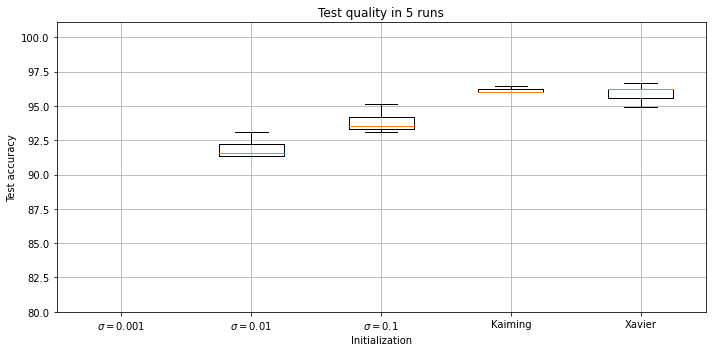

In [97]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются на контроле качество и устойчивость процесса обучения при различных инициализациях?
* Какие инициализации помогают обучать более глубокие сети?

__Ответы:__

По графикам можно сделать вывод, что модель с инициализацей весов из нормального распределения со стандартным отклонением 1e-3 дает худшее качество независимо от глубины сети. В целом, качество повышается при увеличении стандартного отклонения. Наилучшее качество дают инициализации Kaiming и Xavier, разброс у них примерно одинаковый. 
Можно сделать вывод, что для обучения глубоких сетей лучше всего использовать инициализации Kaiming или Xavier.

Теперь сравним скорость обучения при различных инициализациях. Создайте два списка списков `accs_test_on_iterations`, `accs_train_on_iterations` в каждом из которых в позиции `[i]` (см. описание `i` в предыдущем пункте) будет лежать список из значений `accuracy` на тестовой и обучающей выборках соответственно, полученных во время обучения модели. Количество слоев в сети зафиксируйте равным 4.

In [127]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [128]:
accs_test_on_iterations = []
accs_train_on_iterations = []

### your code here
for i in range(len(init_vars)):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=4, activation=ReLU
    )
    dense_network.to(device)
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    init_m = partial(initialize_module, init=init_vars[i])
    dense_network.apply(init_m)
    train_losses, test_losses, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )
    accs_test_on_iterations.append(test_accs)
    accs_train_on_iterations.append(train_accs)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44
Loss (Train/Test): 2.301/2.309. Accuracy, % (Train/Test): 10.69/8.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.69/8.22
Loss (Train/Test): 1.692/1.698. Accuracy, % (Train/Test): 26.87/29.56
Loss (Train/Test): 0.870/0.924. Accuracy, % (Train/Test): 69.64/67.11
Loss (Train/Test): 0.216/0.329. Accuracy, % (Train/Test): 93.24/91.11
Loss (Train/Test): 0.038/0.401. Accuracy, % (Train/Test): 98.81/92.89
Loss (Train/Test): 0.001/1.110. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/3.919. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/5.222. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/5.222. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/5.222. Accuracy, % (Train/Test): 100.00/93.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.296/2.303. Accuracy, % (Train/Test): 10.69/10.00
Loss (Train/Test): 0.593/0.601. Accuracy, % (Train/Test): 81.81/79.11
Loss (Train/Test): 0.121/0.178. Accuracy, % (Train/Test): 96.14/94.89
Loss (Train/Test): 0.005/0.377. Accuracy, % (Train/Test): 99.85/95.78
Loss (Train/Test): 0.000/1.465. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.126. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.126. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.126. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.126. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.126. Accuracy, % (Train/Test): 100.00/95.56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 20.035/21.353. Accuracy, % (Train/Test): 14.92/12.00
Loss (Train/Test): 0.171/0.333. Accuracy, % (Train/Test): 94.14/90.44
Loss (Train/Test): 0.003/0.369. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/1.076. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.105. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.105. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.105. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.105. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.105. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.105. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.068/7.383. Accuracy, % (Train/Test): 12.32/13.33
Loss (Train/Test): 0.285/0.265. Accuracy, % (Train/Test): 90.42/91.78
Loss (Train/Test): 0.028/0.254. Accuracy, % (Train/Test): 99.11/94.44
Loss (Train/Test): 0.000/0.783. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.754. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.754. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.754. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.754. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.754. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.754. Accuracy, % (Train/Test): 100.00/95.56


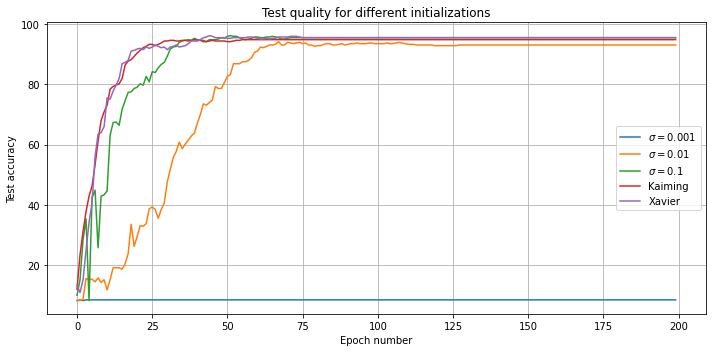

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars_for_plot):
    ax.plot(accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как меняется скорость обучения в зависимости от выбранной инициализации?

__Ответы:__

Скорость обучения у моделей с нормальным распределением больше, чем у моделей с Xavier и Kaiming инициализациями. У модели со стандартным отклонением 1е-3 скорость не увеличивается, но эта реализация показала самое плохое качество обучения.

## Эксперименты c различными функциями активации. [Кросспроверка. 2 балла]

Проверим теперь, с какой функцией активации нейронная сеть будет обучаться лучше.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными функциями активации.

Для этого нам нужно реализовать еще $2$ слоя: для функций активации `Tanh` и `Sigmoid`.

In [101]:
class Tanh(torch.nn.Module):
    def __init__(self):
        """
        tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
        Используйте функцию torch.tanh для подсчета гиперболического тангенса.
        Вы можете сами реализовать подсчет tanh, но тогда вам нужно устойчиво его вычислять.
        """
        super().__init__()
        ### your code here
        self.func = torch.tanh

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Поэлементное применение Tanh
        """
        return self.func(x)

    def __repr__(self):
        return 'Tanh()'

In [102]:
class Sigmoid(torch.nn.Module):
    def __init__(self):
        """
        sigmoid(y) = 1 / (1 + e^(-y))
        Используйте функцию torch.special.expit для подсчета сигмоиды.
        Вы можете сами реализовать подсчет сигмоиды, но тогда вам нужно устойчиво ее вычислять.
        """
        super().__init__()
        ### your code here
        self.func = torch.special.expit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Поэлементное применение Sigmoid
        """
        ### your code here
        return self.func(x)

    def __repr__(self):
        return 'Sigmoid()'

Теперь попробуйте для каждой из 3 функций активации обучить нейронную сеть несколько раз. Число слоев зафиксируйте равным $3$. В случае `Tanh` и `Sigmoid` используйте инициализацию `Xavier`, а в случае `ReLU` используйте инициализацию `Kaiming`.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с функцией активации $ReLU$ при $i = 0$, с функцией активации $Tanh$ при $i = 1$ и с функцией активации $Sigmoid$ при $i = 2$.

In [103]:
act_func_vars = ['Tanh', 'Sigmoid', 'ReLU']
init_for_act_funcs = ['Xavier', 'Xavier', 'Kaiming']

In [104]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [105]:
### your code here
act_func_list = [Tanh, Sigmoid, ReLU]
for i in range(len(act_func_vars)):
    for j in range(5):
        dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=3, activation=act_func_list[i]
        )
        dense_network.to(device)
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()
        init_m = partial(initialize_module, init=init_for_act_funcs[i])
        dense_network.apply(init_m)
        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn, 
            optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
        )
        accs_train[i][j] = train_accs[-1]
        accs_test[i][j] = test_accs[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.346/2.351. Accuracy, % (Train/Test): 12.84/13.33
Loss (Train/Test): 0.201/0.363. Accuracy, % (Train/Test): 93.54/90.00
Loss (Train/Test): 0.055/0.374. Accuracy, % (Train/Test): 98.37/90.89
Loss (Train/Test): 0.010/0.514. Accuracy, % (Train/Test): 99.85/91.56
Loss (Train/Test): 0.001/0.803. Accuracy, % (Train/Test): 99.93/92.00
Loss (Train/Test): 0.001/1.259. Accuracy, % (Train/Test): 99.93/91.33
Loss (Train/Test): 0.001/1.738. Accuracy, % (Train/Test): 100.00/90.44
Loss (Train/Test): 6526.900/7401.139. Accuracy, % (Train/Test): 64.07/63.11
Loss (Train/Test): 6871610368.000/6771344896.000. Accuracy, % (Train/Test): 10.24/10.67
Loss (Train/Test): 1822937472.000/1748044032.000. Accuracy, % (Train/Test): 21.68/19.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.688/2.636. Accuracy, % (Train/Test): 8.54/9.78
Loss (Train/Test): 0.234/0.333. Accuracy, % (Train/Test): 94.06/90.67
Loss (Train/Test): 1.374/1.400. Accuracy, % (Train/Test): 58.35/59.11
Loss (Train/Test): 5673.458/5659.437. Accuracy, % (Train/Test): 3.41/5.11
Loss (Train/Test): 93040.672/94684.922. Accuracy, % (Train/Test): 10.02/11.11
Loss (Train/Test): 35130300.000/37363260.000. Accuracy, % (Train/Test): 22.12/21.56
Loss (Train/Test): 191622800.000/208060336.000. Accuracy, % (Train/Test): 9.87/8.44
Loss (Train/Test): 7479730176.000/7828892160.000. Accuracy, % (Train/Test): 7.72/5.56
Loss (Train/Test): 18700290048.000/19072530432.000. Accuracy, % (Train/Test): 8.24/6.00
Loss (Train/Test): 3941332992.000/4151580416.000. Accuracy, % (Train/Test): 32.89/32.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.519/2.481. Accuracy, % (Train/Test): 8.83/11.78
Loss (Train/Test): 0.154/0.217. Accuracy, % (Train/Test): 95.25/94.22
Loss (Train/Test): 0.037/0.297. Accuracy, % (Train/Test): 98.96/93.56
Loss (Train/Test): 0.007/0.325. Accuracy, % (Train/Test): 99.93/94.44
Loss (Train/Test): 0.001/0.449. Accuracy, % (Train/Test): 99.93/93.56
Loss (Train/Test): 0.001/0.766. Accuracy, % (Train/Test): 99.93/93.33
Loss (Train/Test): 0.001/1.053. Accuracy, % (Train/Test): 99.93/93.33
Loss (Train/Test): 0.001/1.323. Accuracy, % (Train/Test): 99.93/93.11
Loss (Train/Test): 1557535.125/1555768.375. Accuracy, % (Train/Test): 3.49/4.22
Loss (Train/Test): 297255968.000/309880864.000. Accuracy, % (Train/Test): 11.88/12.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.408/2.418. Accuracy, % (Train/Test): 11.14/11.56
Loss (Train/Test): 0.137/0.245. Accuracy, % (Train/Test): 96.07/92.44
Loss (Train/Test): 0.011/0.379. Accuracy, % (Train/Test): 99.78/92.22
Loss (Train/Test): 0.001/0.643. Accuracy, % (Train/Test): 100.00/91.56
Loss (Train/Test): 0.000/1.035. Accuracy, % (Train/Test): 100.00/91.33
Loss (Train/Test): 0.002/1.534. Accuracy, % (Train/Test): 99.93/90.89
Loss (Train/Test): 0.000/1.748. Accuracy, % (Train/Test): 100.00/91.33
Loss (Train/Test): 0.000/2.022. Accuracy, % (Train/Test): 100.00/90.67
Loss (Train/Test): 0.000/2.189. Accuracy, % (Train/Test): 100.00/90.44
Loss (Train/Test): 0.000/2.189. Accuracy, % (Train/Test): 100.00/90.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.404/2.430. Accuracy, % (Train/Test): 13.29/12.44
Loss (Train/Test): 0.205/0.309. Accuracy, % (Train/Test): 94.65/90.67
Loss (Train/Test): 0.034/0.274. Accuracy, % (Train/Test): 99.11/93.33
Loss (Train/Test): 0.004/0.351. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.000/0.524. Accuracy, % (Train/Test): 100.00/92.89
Loss (Train/Test): 0.000/0.727. Accuracy, % (Train/Test): 100.00/93.11
Loss (Train/Test): 0.000/0.973. Accuracy, % (Train/Test): 100.00/92.44
Loss (Train/Test): 1781156.000/1838623.125. Accuracy, % (Train/Test): 12.92/9.33
Loss (Train/Test): 4994916.500/5053303.500. Accuracy, % (Train/Test): 25.02/22.22
Loss (Train/Test): 5499084.000/5647179.000. Accuracy, % (Train/Test): 14.25/14.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.503/2.561. Accuracy, % (Train/Test): 9.73/11.11
Loss (Train/Test): 0.341/0.421. Accuracy, % (Train/Test): 89.90/86.89
Loss (Train/Test): 0.129/0.273. Accuracy, % (Train/Test): 96.21/92.67
Loss (Train/Test): 0.062/0.424. Accuracy, % (Train/Test): 98.00/92.00
Loss (Train/Test): 0.028/0.648. Accuracy, % (Train/Test): 98.89/90.67
Loss (Train/Test): 0.088/0.824. Accuracy, % (Train/Test): 97.70/91.33
Loss (Train/Test): 0.008/1.010. Accuracy, % (Train/Test): 99.78/90.67
Loss (Train/Test): 0.018/1.120. Accuracy, % (Train/Test): 99.48/91.33
Loss (Train/Test): 252.860/254.740. Accuracy, % (Train/Test): 10.47/10.67
Loss (Train/Test): 175.766/170.045. Accuracy, % (Train/Test): 32.00/32.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.467/2.496. Accuracy, % (Train/Test): 10.10/10.44
Loss (Train/Test): 0.349/0.514. Accuracy, % (Train/Test): 89.68/88.44
Loss (Train/Test): 0.102/0.425. Accuracy, % (Train/Test): 97.33/92.22
Loss (Train/Test): 0.044/0.475. Accuracy, % (Train/Test): 98.59/92.89
Loss (Train/Test): 0.019/0.666. Accuracy, % (Train/Test): 99.33/92.67
Loss (Train/Test): 0.006/0.953. Accuracy, % (Train/Test): 99.93/93.11
Loss (Train/Test): 0.003/1.350. Accuracy, % (Train/Test): 99.93/92.89
Loss (Train/Test): 4996.421/4938.879. Accuracy, % (Train/Test): 0.15/0.22
Loss (Train/Test): 383724.875/385550.688. Accuracy, % (Train/Test): 9.73/11.11
Loss (Train/Test): 71307.156/71197.281. Accuracy, % (Train/Test): 3.49/5.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.441/2.464. Accuracy, % (Train/Test): 10.54/8.44
Loss (Train/Test): 0.334/0.525. Accuracy, % (Train/Test): 90.20/86.44
Loss (Train/Test): 0.149/0.462. Accuracy, % (Train/Test): 95.40/91.11
Loss (Train/Test): 0.069/0.478. Accuracy, % (Train/Test): 97.85/91.56
Loss (Train/Test): 0.037/0.609. Accuracy, % (Train/Test): 99.11/91.56
Loss (Train/Test): 0.019/0.878. Accuracy, % (Train/Test): 99.41/92.44
Loss (Train/Test): 0.013/1.421. Accuracy, % (Train/Test): 99.55/91.33
Loss (Train/Test): 0.012/2.316. Accuracy, % (Train/Test): 99.55/91.11
Loss (Train/Test): 1310.403/1523.695. Accuracy, % (Train/Test): 59.39/58.44
Loss (Train/Test): 169569.656/180826.672. Accuracy, % (Train/Test): 33.93/28.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.407/2.401. Accuracy, % (Train/Test): 10.84/9.11
Loss (Train/Test): 0.259/0.374. Accuracy, % (Train/Test): 91.91/89.11
Loss (Train/Test): 0.067/0.249. Accuracy, % (Train/Test): 98.07/95.11
Loss (Train/Test): 0.023/0.294. Accuracy, % (Train/Test): 99.41/94.44
Loss (Train/Test): 4.722/5.025. Accuracy, % (Train/Test): 10.62/8.22
Loss (Train/Test): 29629.303/29787.691. Accuracy, % (Train/Test): 17.97/15.11
Loss (Train/Test): 18617170.000/17669266.000. Accuracy, % (Train/Test): 39.64/40.44
Loss (Train/Test): 595186112.000/573099200.000. Accuracy, % (Train/Test): 9.50/11.11
Loss (Train/Test): 114502136.000/116681120.000. Accuracy, % (Train/Test): 15.59/16.44
Loss (Train/Test): 43769868.000/39695020.000. Accuracy, % (Train/Test): 19.15/17.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.405/2.365. Accuracy, % (Train/Test): 10.10/10.44
Loss (Train/Test): 0.223/0.385. Accuracy, % (Train/Test): 93.39/87.33
Loss (Train/Test): 0.057/0.316. Accuracy, % (Train/Test): 98.44/93.78
Loss (Train/Test): 0.022/0.321. Accuracy, % (Train/Test): 99.41/94.44
Loss (Train/Test): 0.010/0.386. Accuracy, % (Train/Test): 99.63/94.44
Loss (Train/Test): 0.010/0.569. Accuracy, % (Train/Test): 99.70/93.33
Loss (Train/Test): 0.004/0.925. Accuracy, % (Train/Test): 99.78/92.22
Loss (Train/Test): 0.004/1.306. Accuracy, % (Train/Test): 99.78/93.11
Loss (Train/Test): 0.003/1.582. Accuracy, % (Train/Test): 99.78/93.11
Loss (Train/Test): 0.003/2.005. Accuracy, % (Train/Test): 99.78/92.89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 51.306/50.380. Accuracy, % (Train/Test): 6.90/8.00
Loss (Train/Test): 0.135/0.297. Accuracy, % (Train/Test): 95.62/92.00
Loss (Train/Test): 0.000/0.281. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.297. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 33.475/34.773. Accuracy, % (Train/Test): 11.06/9.11
Loss (Train/Test): 0.313/0.459. Accuracy, % (Train/Test): 90.20/88.44
Loss (Train/Test): 0.014/0.376. Accuracy, % (Train/Test): 99.63/94.89
Loss (Train/Test): 0.065/0.574. Accuracy, % (Train/Test): 98.07/95.11
Loss (Train/Test): 0.000/0.662. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.967. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.967. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.967. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.967. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.967. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 34.844/34.036. Accuracy, % (Train/Test): 6.76/8.00
Loss (Train/Test): 0.596/0.786. Accuracy, % (Train/Test): 80.85/78.00
Loss (Train/Test): 0.067/0.309. Accuracy, % (Train/Test): 98.52/94.00
Loss (Train/Test): 0.018/0.488. Accuracy, % (Train/Test): 99.48/94.89
Loss (Train/Test): 0.009/0.882. Accuracy, % (Train/Test): 99.63/94.00
Loss (Train/Test): 0.007/1.380. Accuracy, % (Train/Test): 99.63/94.00
Loss (Train/Test): 0.004/2.176. Accuracy, % (Train/Test): 99.70/92.89
Loss (Train/Test): 0.003/2.959. Accuracy, % (Train/Test): 99.93/93.33
Loss (Train/Test): 0.002/4.376. Accuracy, % (Train/Test): 99.93/93.56
Loss (Train/Test): 0.001/5.353. Accuracy, % (Train/Test): 99.93/93.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 68.926/68.273. Accuracy, % (Train/Test): 7.87/7.33
Loss (Train/Test): 0.268/0.383. Accuracy, % (Train/Test): 91.24/88.89
Loss (Train/Test): 0.006/0.242. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.576. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.732. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.732. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.732. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.732. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.732. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.732. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 21.574/20.926. Accuracy, % (Train/Test): 11.58/11.11
Loss (Train/Test): 0.172/0.353. Accuracy, % (Train/Test): 94.65/90.89
Loss (Train/Test): 0.000/0.233. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.386. Accuracy, % (Train/Test): 100.00/96.22


Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

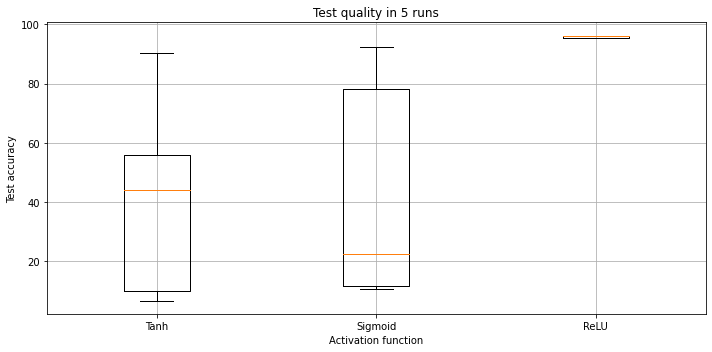

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=act_func_vars, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Activation function")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на контроле и устойчивость процесса обучения при различных функциях активации?

__Ответы:__

Сигмоида и тангенс показали себя хуже, чем ReLU, во всех смыслах.
Однако Тангенс показывает лучшую устойчивость и качество, нежели Сигмоида. 

\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)